<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Limpieza Sentinel-2 (s2_l2a)

Utilizaremos el notebook `02_Limpieza.ipynb` y `03_Análisis_básico.ipynb` como base para el proceso a desarrollar. Reduciremos el área de estudio para aprovechar la mayor resolución espacial de Sentinel-2 con respecto a Landsat-8, utilizado en el notebook anteriormente mencionado.

## 0. Cargar librerías y datos

In [1]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True)

In [2]:
dc = datacube.Datacube(app='limpieza-s2') 

In [3]:
query = {
    "product": "s2_l2a",
    "y": (-33.5, -33.25), 
    "x": (-70.5, -70.25),
    "time": ("2020-01-01", "2020-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-10, 10),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [4]:
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 141, y: 2804, x: 2363)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:42:04.063000 ... 2020-12...
  * y            (y) float64 6.32e+06 6.32e+06 6.32e+06 ... 6.292e+06 6.292e+06
  * x            (x) float64 3.603e+05 3.603e+05 ... 3.839e+05 3.839e+05
    spatial_ref  int32 32719
Data variables: (12/15)
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    rededge1     (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    rededge2     (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    nir09        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    aot          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    wvp          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Podemos observar que obtenemos 141 escenas de 2804 píxeles en el eje y, y 2363 píxeles en el eje x.
Adicionalmente, se obtienen otras bandas que podrían ser de interés, no disponibles en la serie landsat, tales como `rededge1`, `rededge2`, `rededge3`, `nir`, y `nir09`.

Por otra parte, las últimas 3 bandas consisten en: 
* `scl`: Scene Classification
* `aot`: Aerosol Optical Thickness
* `wvp`: Water Vapour

De estas utilizaremos `scl` para enmascarar las imágenes.

***

## 1. Enmascarar valores no válidos y/o no requeridos

En el notebook `02_Limpieza.ipynb` mencionamos 2 maneras obtener las máscaras que eran equivalentes, llamadas `AND` y `OR`. 

Para el caso de `Sentinel-2` no podemos usar el operador lógico `AND`, debido a diferencias en el diccionario. Por este motivo utilizarémos el operador lógico `OR`

### 1.1 Operador lógico `OR`


Para observar la descripción de los flags utilizaremos:

In [5]:
datacube.utils.masking.describe_variable_flags(ds)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


Aquí podemos observar que solo tenemos la fila `qa`, que es equivalente a `qa_pixel` en landsat-8.

Podemos explorar los valores que posee la fila `qa`:

In [6]:
datacube.utils.masking.describe_variable_flags(ds)["values"]["qa"]

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

Recordemos que, bajo este operador, debemos marcar los píxeles que no queremos, para sacarlos.

Obtengamos la máscara para `cloud high probability` y `thin cirrus`:

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


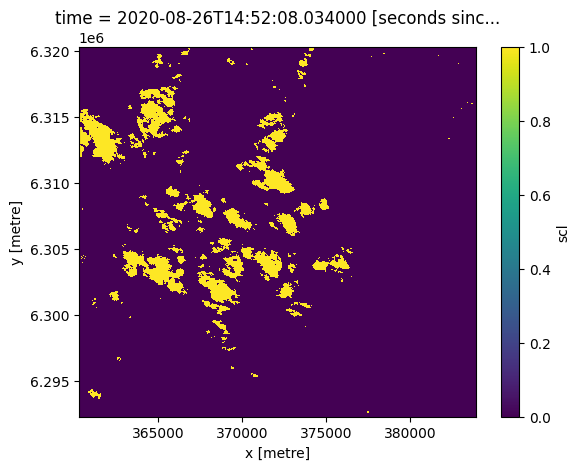

In [7]:
(masking.make_mask(ds.scl, qa="cloud high probability") | masking.make_mask(ds.scl, qa="thin cirrus")).sel(time = "2020-08-26").plot()

Revisemos la máscara con las nubes de la escena en falsos colores (FC):
* La primera imagen es un FC `RGB`.
* La segunda imagen es la máscara
* La tercera imagen un FC `swir22` `swir16` `red`

La tercera imagen permite diferenciar nubes de nieve, debido a que la última se presenta con colores azules.

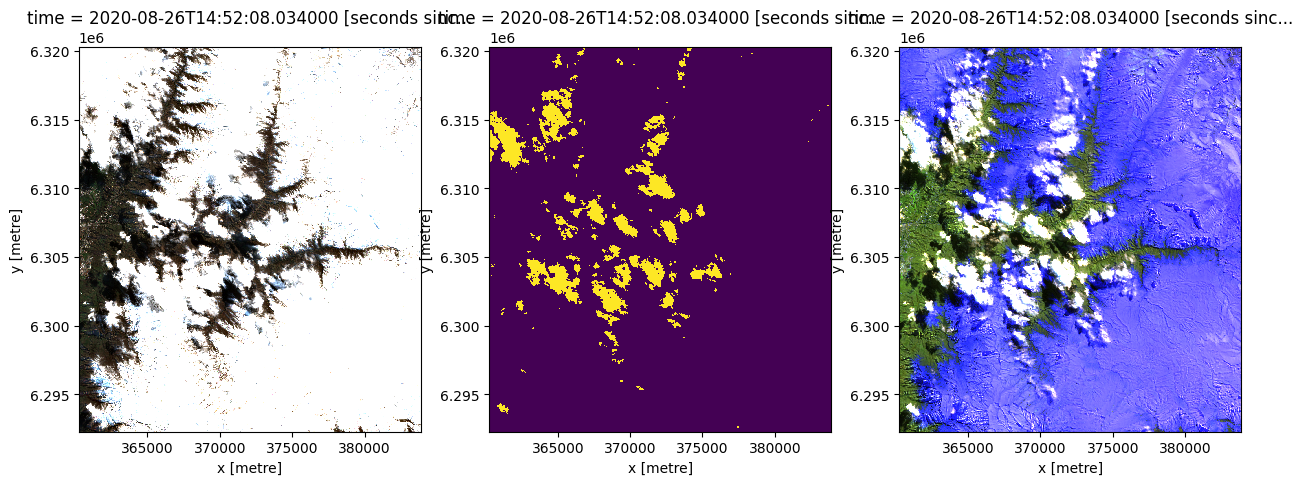

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
ds[["red", "green", "blue"]].sel(time = "2020-08-26").squeeze().to_array().plot.imshow(vmin=0, vmax=3000, robust=True, ax = axs[0])
(masking.make_mask(ds.scl, qa="cloud high probability") | masking.make_mask(ds.scl, qa="thin cirrus")).sel(time = "2020-08-26").plot(add_colorbar=False, ax = axs[1])
ds[["swir22", "swir16", "red"]].sel(time = "2020-08-26").squeeze().to_array().plot.imshow(vmin=0, vmax=3000, robust=True, ax = axs[2])

Podemos observar coincidencias entre las nubes y la máscara que creamos.

Ahora excluyamos los valores que no requerimos:

In [9]:
cloud_free_mask = (
    masking.make_mask(ds.scl, qa="no data") | 
    masking.make_mask(ds.scl, qa="cloud shadows") | 
    masking.make_mask(ds.scl, qa="cloud high probability") |
    masking.make_mask(ds.scl, qa="thin cirrus") 
)

In [11]:
bandas_reflectancia = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22"]

In [12]:
dsf = xr.where(cloud_free_mask, np.nan, ds[bandas_reflectancia])

In [14]:
dsf

<xarray.Dataset>
Dimensions:      (time: 141, y: 2804, x: 2363)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:42:04.063000 ... 2020-12...
  * y            (y) float64 6.32e+06 6.32e+06 6.32e+06 ... 6.292e+06 6.292e+06
  * x            (x) float64 3.603e+05 3.603e+05 ... 3.839e+05 3.839e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Podemos notar que `dsf` solo posee como variables aquellas bandas incluidas en `bandas_reflectancia`.

En la siguiente imagen podemos ver el FC `swir22` `swir16` `red`, y en negro se aprecia los píxeles excluidos mediante la máscara

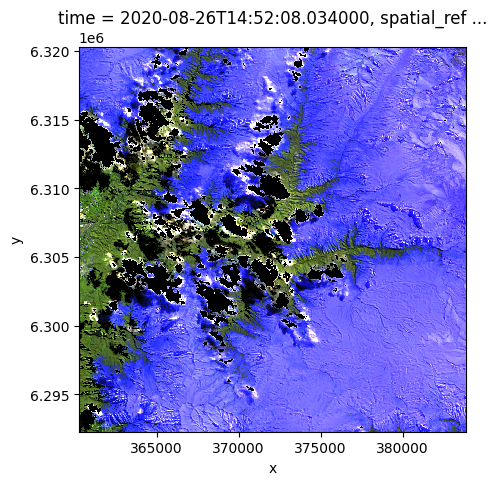

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
dsf[["swir22", "swir16", "red"]].sel(time = "2020-08-26").squeeze().to_array().plot.imshow(vmin=0, vmax=3000, robust=True, ax = ax)
ax.set_facecolor("black")

Se aprecia el resultado esperado, la exclusión de nubes y sus sombras mediante la banda de calidad de Sentinel-2.

***

# 2. Reescalar valores digitales a reflectancia
Es siempre necesario transformar los valores digitales a reflectancia antes de continuar con cualquier análisis. Para el producto Sentinel-2 Level 2A esta es la [documentación oficial](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html).

¿Cómo sabemos que tenemos valores digitales?, porque los valores de reflectividad debe ser un decimal entre 0 y 1.
Si graficamos una banda en particular, por ejemplo la banda roja, podemos observar el rango de valores que toma la imagen.

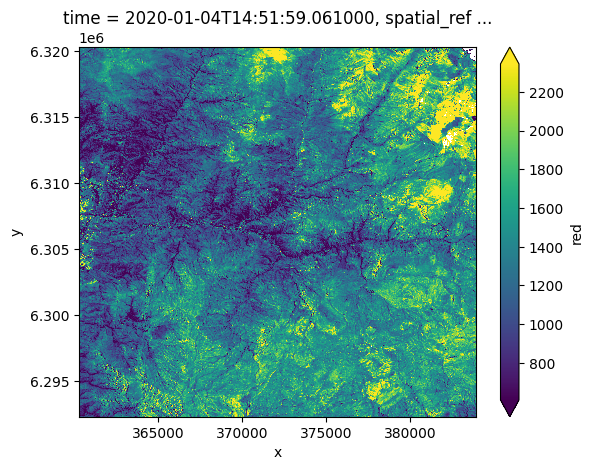

In [20]:
dsf.red.isel(time = 1).plot(robust = True)

Es posible observar valores entre 800 y 2200, muy lejano de los decimales entre 0 y 1 que requerimos.

Como estamos utilizando Sentinel 2 debemos corregir utilizando `ND*0.0001`, donde `ND` es el valor que posee cada pixel en cada banda, esto lo hacemos con el siguiente código:

In [24]:
dsf.update(dsf * 0.0001)

<xarray.Dataset>
Dimensions:      (time: 141, y: 2804, x: 2363)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:42:04.063000 ... 2020-12...
  * y            (y) float64 6.32e+06 6.32e+06 6.32e+06 ... 6.292e+06 6.292e+06
  * x            (x) float64 3.603e+05 3.603e+05 ... 3.839e+05 3.839e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Luego, debemos mantener solo los valores que sean válidos. Debido a que la reflectancia debiese entregar valores entre 0 y 1, debemos quedarnos solo con esos valores:

In [27]:
dsf.update(dsf.where(dsf >= 0).where(dsf <= 1))

<xarray.Dataset>
Dimensions:      (time: 141, y: 2804, x: 2363)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:42:04.063000 ... 2020-12...
  * y            (y) float64 6.32e+06 6.32e+06 6.32e+06 ... 6.292e+06 6.292e+06
  * x            (x) float64 3.603e+05 3.603e+05 ... 3.839e+05 3.839e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Volvemos a graficar, notando que ahora los valores en la escala de la derecha de la imagen han cambiado.

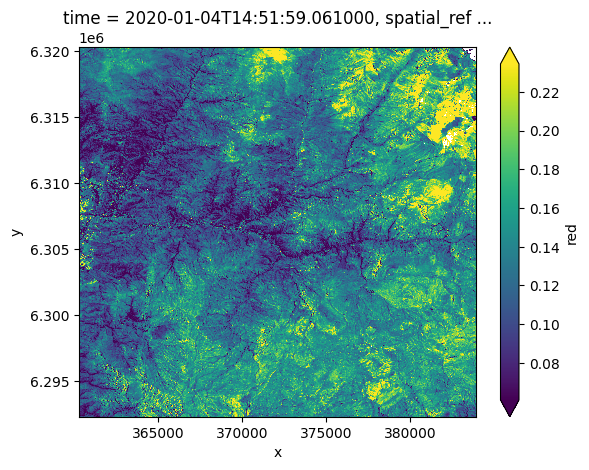

In [25]:
dsf.red.isel(time = 1).plot(robust = True)

In [ ]:
client.close()

cluster.close()

***